# Project Midpoint

This notebook demonstrates,
1. The PageRank Algorithm Theory
2. The PageRank Algorithm theoretical complexity
3. Implementing PageRank on social networks and its theoretical complexity using small graphs generated from NetworkX


# ------------------------------------------------------------------

# Introduction:
PageRank (PR) is an algorithm which rank websites in their Google Search engine results. PR is one of approaches to measuring the importance of website pages by calculating ranks based on the proportional rank.

### PageRank Theory
The PR ranks depend on the number of pages, damping factor, and a number of iterations. The PageRank relies on an arbitrary probability distribution in which a person randomly clicks on links will arrive at any particular page. The probability which a person independently will continue is a damping fator d. PR computations require iterations through a number of pages to adjust approximate PR values to the theoretical value.

### Theoretical Complexity
- Time Complexity O(k*N) where k represents the specific number of repeats of the code that needs to be run on page N.
- Space Complexity O(N), meaning that it takes up as much space as the number of pages in Google. 


### PageRank Equation
The iteration equation of the page rank value of  𝑖  is given by

**PR(n) = (1-d)/N + d*(PR(n1)/num_neighbors(n1) + ... + PR(n_last)/num_neighbors(n_last))**

where the damping factor $d=D$, $\frac{d}{n}$ denotes random walk score, $OutputDegree(P_j)$ denote how many pages are linked as children pages for the page $j$.

# Implementing PageRank on social networks

We will implement the PageRank algorithm and utilize it on social networks graphs provided by Networkx.


## Preprocessing Steps:
1. Converting non-directed graph to a directed graph 
2. Relabelling nodes as integers (encoding string names to unique node IDs)
3. Remove isolated nodes


In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


# Theoretical Complexity of Processing Steps
Time: O(n + m) = checking all nodes O(n) + building adjList O(m + n) + removing isolated node O(n)
Space: O(n + m) => adjList

- check all nodes for converting to directed Graph for PageRank: O(n)
- Build adjList: O(n + m) where n is number of nodes and m is number of edges
- Removing Isolated Nodes: O(n)

In [2]:
G = nx.karate_club_graph()

def make_graph(G):
    # converting to directed Graph for PageRank # O(n)
    if not nx.is_directed(G): # O(n)
        G = G.to_directed() # O(1)

    # labelling nodes as integers
    n_unique_nodes = len(set(G.nodes())) # O(1)
    node2int = dict(zip(set(G.nodes()), range(n_unique_nodes))) # O(n)
    int2node = {v: k for k, v in node2int.items()} # O(n)
    G = nx.relabel_nodes(G, node2int) # O(1)
    
    # remove isolated nodes
    nodes = G.nodes() #O(1)
    for node in nodes: # O(n)
        if len(G.edges(node)) == 0: # O(1)
            G.remove_node(node)
    return G, int2node


### Implementing PageRank Algorithm on Social Networks

## Assumption
- Assume a random surfer who starts surfing from one of the webpages available and keeps surfing from one webpage to another by clicking hyperlinks, until he restarts from any of the webpages and follows the same process.
- All graphs are directed
- Assume that people end up on pages which are more important than other pages.
- Assume the important links have more important links connecting to than other links
- Assume less important links have least number of connections that people are less likely to end up staying in bad link
- The probability distribution which people suffer will modelled as Markov Chain

# Random Surfer Model
## Factors
- **Markov Chain Model**: We will be using Markov Chain model to predict a person randomly surf links. Next state of surfer depends on the current state of surfer.

-  **Absorbing nodes**: Nodes which have an incoming link but not outgoing link. In this case, we assume that if random surfer happens to land at such node, they can migrate to any of the all nodes with equal probability. This helps the algorithm to converge.

- **Restart probability (alpha)**: Often a random surfer might not want to keep following hyperlinks but restart the search process. To model this, we say that there is a certain probability for random surfer to restart.

## Model Representation
- The probability distribution of state transitions represented as matrix
- f the Markov chain has N possible states, the matrix will be an N x N matrix, such that entry (I, J) is the probability of transitioning from state I to state J. 
- Aditionally, the transition matrix must be a stochastic matrix, a matrix whose entries in each row must add up to exactly 1. This makes complete sense, since each row represents its own probability distribution.



# Theoretical Complexity implementing PageRank on Social Network

## Building PageRank Matrix:
time: O(n^2)
space: O(n^2)

- building adjacent matrix: O(n^2)
- building transition probability matrix: O(n^2)
- building random surfer matrix: O(n^2)
- building transition matrix for absorbing nodes: O(n^2)
  

In [10]:
def make_pagerank_matrix(G, alpha):
    n_nodes = len(G.nodes()) # O(1)

    # building adjacent matrix
    adj_matrix = np.zeros(shape=(n_nodes, n_nodes)) # O(n^2) time & space
    for edge in G.edges(): # O(m) 
        adj_matrix[edge[0], edge[1]] = 1

    # building transition probability matrix
    tran_matrix = adj_matrix / np.sum(adj_matrix, axis=1).reshape(-1, 1) # O(1)

    # building random surfer matrix
    random_surf = np.ones(shape=(n_nodes, n_nodes)) / n_nodes # O(n^2)

    # building transition matrix for absorbing nodes
    absorbing_nodes = np.zeros(shape=(n_nodes,)) # O(n^2) space
    for node in G.nodes(): # O(n)
        if len(G.out_edges(node)) == 0:
            absorbing_nodes[node] = 1
    absorbing_node_matrix = np.outer(absorbing_nodes, np.ones(shape=(n_nodes,))) / n_nodes # O(1)

    # stochastic matrix
    stochastic_matrix = tran_matrix + absorbing_node_matrix # O(1)

    # pagerank matrix
    pagerank_matrix = alpha * stochastic_matrix + (1-alpha) * random_surf # O(1)
    return pagerank_matrix # O(1)


## Random Walk

- We start with an initial state where the surfer has equal probability to start at any of the pages. 
- We have modelled the transition matrix (pagerank matrix) which helps in finding the transition probabilites for the next state given current state.
- The algorithm will converge when there is approximately no difference between two consecutive states. At this point, the vector of probabilities can be seen as probabilities a user is likely to end up in general, and these can be treated as PageRank scores. A higher probability will mean that the webpage/link is more important and vice versa.

## Random Walk Algorithm Theoretical Complexity
- time: O(k * n) where k is number of iterations, n = number of nodes

In [9]:
def random_walk(G, alpha, n_iter):
    n_nodes = len(G.nodes()) # O(1)
    initial_state = np.ones(shape=(n_nodes,)) / n_nodes #  O(1)
    pagerank_matrix = make_pagerank_matrix(G, alpha) # O(1) calling function

    new_initial_state = initial_state # O(1)
    for i in range(n_iter): # O(k) where k is number of iterations
        final_state = np.dot(np.transpose(pagerank_matrix), new_initial_state) # O(1)
        prev_initial_state = new_initial_state # O(1)
        new_initial_state = final_state # O(1)

    return final_state


# Data Visulaization

In [12]:
def plot_graph(G, final_probs, int2node, bool_final_probs=False):
    labels = int2node

    try:
        clubs = np.array(list(map(lambda x: G.nodes[x]['club'], G.nodes())))
        labels = dict(zip(G.nodes(), clubs))
    except:
        pass

    if not bool_final_probs:
        nx.draw(G, with_labels=True, alpha=0.8, arrows=False, labels=labels)
    else:
        nx.draw(G, with_labels=True, alpha=0.8, arrows=False, node_color=final_probs,
                cmap=plt.get_cmap('viridis'), labels=labels)
        
        # adding color bar for pagerank importances
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap('viridis'), norm=plt.Normalize(
            vmin=min(final_probs), vmax=max(final_probs)))
        sm._A = []
        plt.colorbar(sm)
    return plt


In [14]:
def run(G, alpha, n_iter):
    G, int2node = make_graph(G)
    final_probs = random_walk(G, alpha, n_iter)

    # ensuring pagerank importance for each node
    assert len(final_probs) == len(G.nodes())
    # ensuring probabilities sum to 1
    assert np.allclose(np.sum(final_probs), 1)

    print()
    print('Pagerank importances..')
    print(final_probs)

    plt.figure(figsize=(25, 8))
    plt.subplot(121)
    plot_graph(G, None, int2node, bool_final_probs=False)
    plt.subplot(122)
    plot_graph(G, final_probs, int2node, bool_final_probs=True)
    plt.show()
    return final_probs


First Sample Graph from Networkk: 
Converged at 23 iterations..


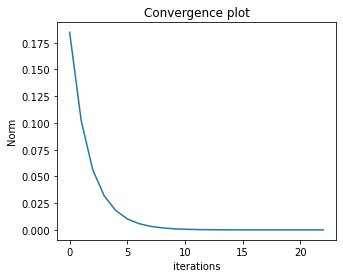


Pagerank importances..
[0.09455921 0.05152265 0.05510965 0.03520661 0.022556   0.02965355
 0.02965355 0.02429308 0.02920398 0.01491851 0.022556   0.01061031
 0.01530453 0.02892046 0.01518063 0.01518063 0.01774383 0.01519009
 0.01518063 0.01981748 0.01518063 0.01519009 0.01518063 0.0313859
 0.02167915 0.02158242 0.01581545 0.02572134 0.01981574 0.02652856
 0.02443306 0.03672917 0.07006385 0.09833262]


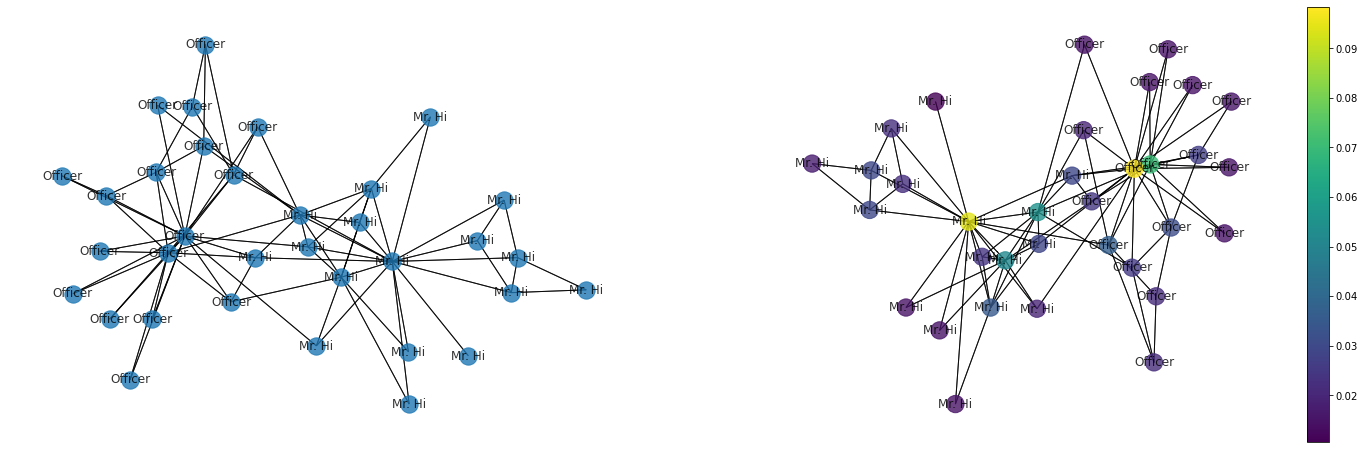



Second Sample Graph from Networkk: 
Converged at 46 iterations..


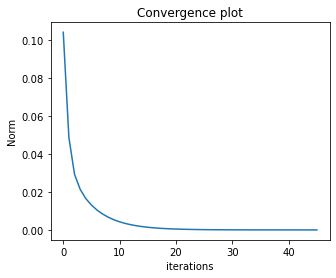


Pagerank importances..
[0.02319995 0.01960249 0.02913123 0.0225989  0.01884531 0.01466343
 0.04145404 0.02283931 0.02836729 0.03366245 0.01880887 0.03829833
 0.02284269 0.0290225  0.03218931 0.0440897  0.01960249 0.02339818
 0.05060149 0.01630935 0.01630935 0.03691868 0.01875878 0.03425017
 0.04127687 0.02379543 0.03659665 0.07048178 0.04095943 0.04193673
 0.02340157 0.06578725]


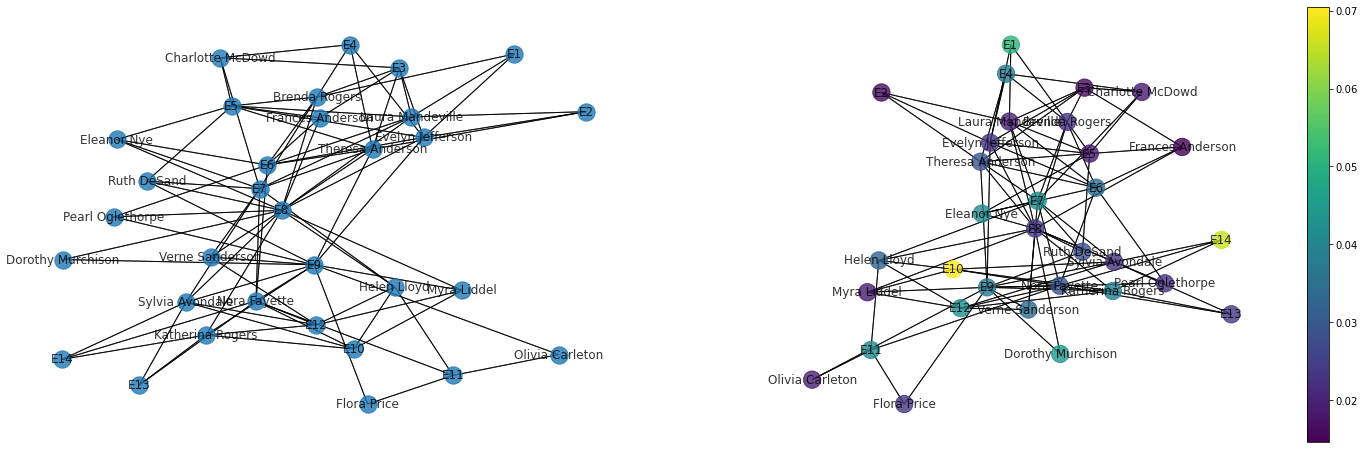

In [21]:
def random_walk(G, alpha, n_iter):
    n_nodes = len(G.nodes()) # O(1)
    initial_state = np.ones(shape=(n_nodes,)) / n_nodes #  O(1)
    pagerank_matrix = make_pagerank_matrix(G, alpha) # building matrix O(n^2)

    new_initial_state = initial_state # O(1)
    NORM = [] # O(1)
    for i in range(n_iter): # O(k) where k is number of iterations
        final_state = np.dot(np.transpose(pagerank_matrix), new_initial_state) # O(1)

        prev_initial_state = new_initial_state # O(1)
        new_initial_state = final_state 
        L2 = np.linalg.norm(new_initial_state-prev_initial_state)
        NORM.append(L2)
        if np.allclose(new_initial_state, prev_initial_state):
            print(f'Converged at {i+1} iterations..')
            break

    plt.figure(figsize=(5, 4))
    plt.plot(range(i+1), NORM)
    plt.xlabel('iterations')
    plt.ylabel('Norm')
    plt.title('Convergence plot')
    plt.show()
    return final_state


alpha = 0.8
n_iter = 10000

print("First Sample Graph from Networkk: ")
G = nx.karate_club_graph()
final_probs = run(G, alpha, n_iter)

print("")
print()

print("Second Sample Graph from Networkk: ")
G = nx.davis_southern_women_graph()
final_probs2 = run(G, alpha, n_iter)




In [ ]:

df = pd.DataFrame(
    {'DS size $n$': N_RUNS, 'QuickSort': b_ops, 'insertion Sort': f_ops})
df.set_index('DS size $n$', drop=True, inplace=True)
fig = df.plot().get_figure()
plt.ylabel('# Operations')
plt.grid()
fig.savefig('fsearch_analysis.png')


# Plan
I am going to empirically analyze the PageRank Algorithm by Counting the number of operations by a counter to for accurate complexity analysis.


# References

https://epjdatascience.springeropen.com/articles/10.1140/epjds/s13688-020-00240-z
https://www2.math.upenn.edu/~kazdan/312F12/JJ/MarkovChains/markov_google.pdf
https://saattrupdan.github.io/2020-08-07-pagerank/
https://www.geeksforgeeks.org/page-rank-algorithm-implementation/
https://towardsdatascience.com/pagerank-3c568a7d2332
https://towardsdatascience.com/introduction-to-markov-chains-50da3645a50d
https://cims.nyu.edu/~holmes/teaching/asa19/handout_Lecture2_2019.pdf
https://networkx.org/documentation/networkx-1.10/reference/generators.html
https://docs.oracle.com/cd/E56133_01/2.4.0/reference/algorithms/pagerank.html#:~:text=PageRank%20From%20Set-,Time%20Complexity%20O(k*N)%20%5Bk%20%3D%20no,a%20given%20set%20of%20nodes.